In [243]:
import torch
from medication_data_script import load_medication_data, LeakageOption
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from medication_bout_script import get_bouts
from sklearn.metrics import ConfusionMatrixDisplay

In [244]:
WINDOW_SIZE = 400
STRIDE = 50
NUM_MED_WINDOWS_TO_SAMP = 45
data_samp_path = '/home/kuba/Documents/data/raw/kuba_watch_data/2024-07-10_06_42_46'

all_bouts, _ = get_bouts('/home/kuba/Documents/data/raw/listerine/3_final', shuffle=True, min_bout_len=400)

WARNING we will sample bouts from all participants there will be data leakage, unless you specify who not to sample from


In [245]:
def get_random_med_bouts(all_bouts):
    bout_picks = []
    idxs_used = []

    for _ in range(NUM_MED_WINDOWS_TO_SAMP):
        pick = random.randint(0, len(all_bouts) - 1)
        while pick in idxs_used:
            pick = random.randint(0, len(all_bouts) - 1)
        
        bout_picks.append(all_bouts[pick]) #add window
        idxs_used.append(pick) #add so we dont reuse same windows

    return bout_picks
    

In [246]:
len(all_bouts)

1724

In [247]:
sampled_bouts = get_random_med_bouts(all_bouts)
len(sampled_bouts)

45

In [248]:
#now we will add the sampled bouts to the data 
def paste_in_bouts(bouts, acc, gyro):

    def is_vaild(i, bout_len, idxs, full_length):
        if i < 0:
            return False
        elif (i + bout_len) > full_length:
            return False
        else:
            for pair in idxs:
                j, j_plus_w = pair #pais of windows we have already pasted
                if ((i + bout_len) >= j) and ((i + bout_len) <=  j_plus_w):
                    return False
                elif ((i) >= j) and ((i) <=  j_plus_w):
                    return False
            return True

    acc_augmented = acc
    gyro_augmented = gyro
    idxs = [] #list of tuples (i, i+bout_len) where each bout is placed
    for bout in bouts:
        bout_acc = bout[:3,:]
        bout_gyro = bout[3:,:]
        print(f"Bout shape - Acc: {len(bout_acc[0])}, Gyro: {len(bout_gyro[0])}")

        valid_placment = False
        while not valid_placment:
            i = random.randint(0, len(acc) -1)
            valid_placment = is_vaild(i,len(bout[0]), idxs, len(acc))

            if valid_placment:
                acc_augmented[i:i+len(bout_acc[0])] = bout_acc.T
                gyro_augmented[i:i+len(bout_acc[0])] = bout_gyro.T
                idxs.append((i, i+len(bout_acc[0]))) 
    
    return acc_augmented, gyro_augmented, idxs            

In [249]:
#accl
accl_path = os.path.join(data_samp_path, "acceleration.csv")
#gyro
gyro_path = os.path.join(data_samp_path, "gyroscope.csv")

acc_with_timestamp = pd.read_csv(accl_path, skiprows=1)
acc_with_timestamp['timestamp']  = (acc_with_timestamp['timestamp'] - acc_with_timestamp['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_acc = get_first_line(os.path.join(full_path, 'acceleration.csv'))

gyro_with_timestamp = pd.read_csv(gyro_path, skiprows=1)
gyro_with_timestamp['timestamp']  = (gyro_with_timestamp['timestamp'] - gyro_with_timestamp['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_gyro_with_timestamp = get_first_line(os.path.join(full_path, 'gyroscope.csv'))

acc = acc_with_timestamp.iloc[:, 1:4].to_numpy()
gyro = gyro_with_timestamp.iloc[:, 1:4].to_numpy() # If we dont do this its 9points x 4) where the first index si the time stamp so we want to remove that

In [250]:
# acc = acc[:200000]
# gyro = gyro[:200000]


In [251]:
acc[0:9].T.shape

(3, 9)

In [252]:
acc_augmented, gyro_augmented, idxs = paste_in_bouts(sampled_bouts, acc, gyro)

Bout shape - Acc: 500, Gyro: 500
Bout shape - Acc: 991, Gyro: 991
Bout shape - Acc: 416, Gyro: 416
Bout shape - Acc: 792, Gyro: 792
Bout shape - Acc: 469, Gyro: 469
Bout shape - Acc: 564, Gyro: 564
Bout shape - Acc: 430, Gyro: 430
Bout shape - Acc: 946, Gyro: 946
Bout shape - Acc: 732, Gyro: 732
Bout shape - Acc: 596, Gyro: 596
Bout shape - Acc: 700, Gyro: 700
Bout shape - Acc: 594, Gyro: 594
Bout shape - Acc: 443, Gyro: 443
Bout shape - Acc: 515, Gyro: 515
Bout shape - Acc: 574, Gyro: 574
Bout shape - Acc: 594, Gyro: 594
Bout shape - Acc: 480, Gyro: 480
Bout shape - Acc: 544, Gyro: 544
Bout shape - Acc: 961, Gyro: 961
Bout shape - Acc: 799, Gyro: 799
Bout shape - Acc: 577, Gyro: 577
Bout shape - Acc: 495, Gyro: 495
Bout shape - Acc: 596, Gyro: 596
Bout shape - Acc: 598, Gyro: 598
Bout shape - Acc: 469, Gyro: 469
Bout shape - Acc: 512, Gyro: 512
Bout shape - Acc: 729, Gyro: 729
Bout shape - Acc: 495, Gyro: 495
Bout shape - Acc: 419, Gyro: 419
Bout shape - Acc: 492, Gyro: 492
Bout shape

____
lets make the windows from the augmented data

In [253]:
def window_maker(data, window_size, stride, flatten):
    """Create windows from time series data."""
    windows = []
    
    if flatten:
        # Flatten x, y, z channels into a single vector per window
        for i in range(0, len(data[:,0]) - window_size + 1, stride):
            window = []
            window.extend(data[:,0][i:i + window_size].tolist())
            window.extend(data[:,1][i:i + window_size].tolist())
            window.extend(data[:,2][i:i + window_size].tolist())
            windows.append(window)
    else:
        # Keep x, y, z as separate channels
        for i in range(0, len(data[:,0]) - window_size + 1, stride):
            window = [
                data[:,0][i:i + window_size].tolist(),
                data[:,1][i:i + window_size].tolist(),
                data[:,2][i:i + window_size].tolist()
            ]
            windows.append(window)
            
    return windows


def process_recording(acc_data, gyro_data, window_size, stride, flatten):
    """Extract activity windows and labels from a recording."""

    if len(acc) >= window_size:
        acc_windows_batch = window_maker(acc_data, window_size, stride, flatten)
        gyro_windows_batch = window_maker(gyro_data, window_size, stride, flatten)

        # Handle potential mismatch in window counts
        min_windows = min(len(acc_windows_batch), len(gyro_windows_batch))
        acc_windows_batch = acc_windows_batch[:min_windows]
        gyro_windows_batch = gyro_windows_batch[:min_windows]
    
    return torch.tensor(acc_windows_batch), torch.tensor(gyro_windows_batch)

In [254]:
len(acc_augmented[:,0])

2595973

In [255]:
acc_windows, gyro_windows = process_recording(acc_augmented, gyro_augmented, window_size=WINDOW_SIZE, stride=STRIDE, flatten=False)
acc_windows.shape, gyro_windows.shape

(torch.Size([51912, 3, 400]), torch.Size([51912, 3, 400]))

In [256]:
all_windows = torch.cat((acc_windows, gyro_windows), dim=1)
all_windows.shape

torch.Size([51912, 6, 400])

---- 

now lets define the model

In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simple_cnn(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.c0  = nn.Conv1d(6, 64, kernel_size=3, stride=2)

        self.c1  = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.c2  = nn.Conv1d(128, 128, kernel_size=3)

        self.c3  = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        self.c4  = nn.Conv1d(256, 256, kernel_size=3)
        self.c5  = nn.Conv1d(256, 256, kernel_size=3)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.l0 = nn.Linear(256,256)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(256,1)
            
        
    def forward(self, x):
        x = F.relu(self.c0(x), inplace=True)
        
        x = F.relu(self.c1(x), inplace=True)
        x = F.relu(self.c2(x), inplace=True)
        
        x = F.relu(self.c3(x), inplace=True)
        x = F.relu(self.c4(x), inplace=True)
        x = F.relu(self.c5(x), inplace=True)
        
        x = self.gap(x).squeeze(-1)
        x = F.relu(self.l0(x), inplace=True)
        x = self.dropout(x)
        x = self.out(x)
        
        return x


In [258]:
model = simple_cnn()
model.load_state_dict(torch.load('/home/kuba/projects/medication-taking-data/new_start/week03/01_augment_loss_weights/92f1_Augmented_loss_weights_simpcnn_09posweight.pth', weights_only=True))

<All keys matched successfully>

In [259]:
device = 'cuda:0'
model = model.to(device)
all_windows = all_windows.to(device)
with torch.no_grad():
    model.eval()
    logits = model(all_windows)

____

process the results

In [260]:
preds = F.sigmoid(logits.cpu())
preds

tensor([[6.4222e-28],
        [8.1273e-21],
        [5.3736e-28],
        ...,
        [8.5193e-01],
        [1.4791e-01],
        [5.4074e-01]])

In [261]:
preds_list = preds.tolist()
preds_list = [val[0] for val in preds_list]
preds_list.reverse()

In [262]:
counts = np.zeros((len(acc)))
sums = np.zeros((len(acc)))

len_to_use = min(len(acc) - WINDOW_SIZE, len(gyro) - WINDOW_SIZE) #Handle potential mismatch in window count
for i in range(0, len_to_use, STRIDE):
    val = preds_list.pop()
    sums[i : i+WINDOW_SIZE] += val
    counts[i : i+WINDOW_SIZE] += 1


In [263]:
def smooth_predictions(prediction_sum, counts):
    """
    Smooth predictions by averaging, handling divisions by zero.
    """

    averaged_predictions = prediction_sum / (counts + 0.00001)
    return averaged_predictions


In [264]:
avg_preds = smooth_predictions(sums, counts)


In [265]:
max(avg_preds)

np.float64(0.9999987500015626)

In [282]:
# def count_peaks_above_threshold(array, threshold):
#     if len(array) < 3:  # Need at least 3 points to have a peak
#         return 0
    
#     peak_count = 0
#     in_plateau = False
    
#     for i in range(1, len(array) - 1):
#         # Start of a potential peak/plateau
#         if array[i] > array[i-1] and array[i] >= threshold:
#             # Check if we're already counting a plateau
#             if not in_plateau:
#                 in_plateau = True
#                 peak_count += 1
#         # End of a plateau
#         elif in_plateau and array[i] > array[i+1]:
#             in_plateau = False
#         # If values decrease, we're no longer in a plateau
#         elif in_plateau and array[i] < array[i-1]:
#             in_plateau = False
    
#     return peak_count
def count_peaks_above_threshold(array, threshold):
    if len(array) < 3:  # Need at least 3 points to have a peak
        return 0
    
    peak_count = 0
    in_peak = False
    
    for i in range(1, len(array)):
        # Start of a potential peak (value rises above threshold)
        if not in_peak and array[i] > threshold and array[i] > array[i-1]:
            in_peak = True
            peak_count += 1
        
        # End of peak (value falls below threshold)
        elif in_peak and array[i] <= threshold:
            in_peak = False
    
    return peak_count

thresh = 0.95
result = count_peaks_above_threshold(avg_preds, thresh)
print(f"Number of peaks above threshold {thresh}: {result}")

Number of peaks above threshold 0.95: 44


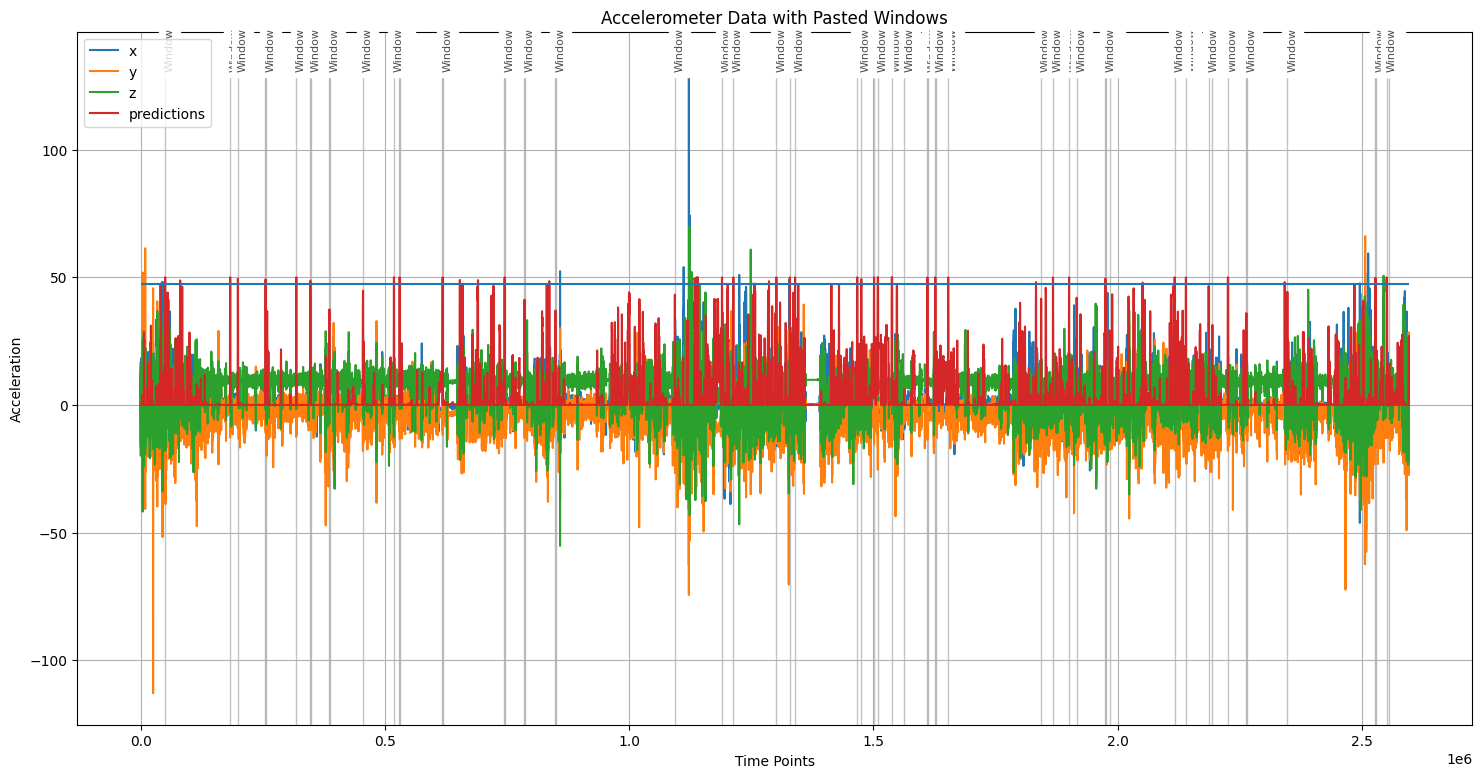

: 

In [ ]:

plt.figure(figsize=(18, 9))

# Plot the accelerometer data
plt.plot(acc_augmented[:,0], label='x')
plt.plot(acc_augmented[:,1], label='y')
plt.plot(acc_augmented[:,2], label='z')
plt.plot((avg_preds * 50), label='predictions')
plt.hlines([(thresh * 50)], xmin=0, xmax=len(acc_augmented[:,0]))

# Add shaded areas for each window that was pasted
for idx_pair in idxs:
    start_idx, end_idx = idx_pair
    plt.axvspan(start_idx, end_idx, color='darkgray', alpha=0.7)
    # Optionally add text labels for each window
    plt.text(start_idx, plt.ylim()[1]*0.9, f"Window", 
             fontsize=8, rotation=90, backgroundcolor='white', alpha=0.7)

plt.grid()
plt.legend()
plt.title('Accelerometer Data with Pasted Windows')
plt.xlabel('Time Points')
plt.ylabel('Acceleration')
plt.show()

In [268]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Define data range
start_idx = 75000
end_idx = 100000
confidance_threshold = 0.8
x_range = list(range(end_idx - start_idx))

# Add traces
fig.add_trace(go.Scatter(x=x_range, y=acc_augmented[start_idx:end_idx, 0], mode='lines', name='x'))
fig.add_trace(go.Scatter(x=x_range, y=acc_augmented[start_idx:end_idx, 1], mode='lines', name='y'))
fig.add_trace(go.Scatter(x=x_range, y=acc_augmented[start_idx:end_idx, 2], mode='lines', name='z'))
fig.add_trace(go.Scatter(x=x_range, y=(avg_preds[start_idx:end_idx] * 40), mode='lines', name='avg_preds*40'))
fig.add_shape(type='line', x0=0, y0=(40*confidance_threshold), x1=len(x_range), y1=(40*confidance_threshold)) 

# Add shaded areas for each window that was pasted
for idx_pair in idxs:
    start_window, end_window = idx_pair
    
    # Only show windows that fall within our visible range
    if end_window >= start_idx and start_window <= end_idx:
        # Adjust indices to match the visible range
        visible_start = max(0, start_window - start_idx)
        visible_end = min(end_idx - start_idx, end_window - start_idx)
        
        y_min = -50
        
        y_max = 50
        
        # Add shaded rectangle
        fig.add_shape(
            type="rect",
            x0=visible_start,
            x1=visible_end,
            y0=y_min,
            y1=y_max,
            fillcolor="darkgray",
            opacity=0.8,
            layer="below",
            line_width=0,
        )
        
        # Add annotation for each window
        fig.add_annotation(
            x=visible_start + (visible_end - visible_start)/2,
            y=y_max,
            text="Window",
            showarrow=False,
            bgcolor="white",
            opacity=0.7
        )

# Update layout
fig.update_layout(
    title='Accelerometer Data with Pasted Windows',
    xaxis_title='Index',
    yaxis_title='Value',
    height=800,
    width=1200
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# Display the figure
fig.show()

In [269]:
def overlap_calc(window_start, window_size, idxs):
    window_end = window_start + window_size
    max_overlap = 0.0
    
    for start, end in idxs:
        # see if there is overlap
        overlap_start = max(window_start, start)
        overlap_end = min(window_end, end)
        
        if overlap_end > overlap_start:  # if true there is an overlap
            overlap_length = overlap_end - overlap_start
            overlap_percentage = overlap_length / window_size
            max_overlap = max(max_overlap, overlap_percentage)
    
    return max_overlap

In [270]:
def count_medication_taking_predictions(avg_preds, idxs, window_size, stride, conf_threshold, overlap_threshold=0.45):
    TPs = 0
    TNs = 0
    FPs = 0
    FNs = 0
    total_num_windows = 0
    for i in range(0, len(avg_preds) - window_size, stride):
        total_num_windows += 1
        window = avg_preds[i: i + window_size]
        window_mean = np.mean(window)
        overlap = overlap_calc(i, window_size, idxs)
        if (window_mean >= conf_threshold) and (overlap < overlap_threshold):
            FPs += 1
        elif(window_mean >= conf_threshold) and (overlap >= overlap_threshold):
            TPs += 1
        elif (window_mean < conf_threshold) and (overlap >= overlap_threshold):
            FNs += 1
        elif (window_mean < conf_threshold) and (overlap < overlap_threshold):
            TNs += 1

    return TPs, TNs, FPs, FNs, total_num_windows  

In [271]:
TP, TN, FP, FN, total = count_medication_taking_predictions(avg_preds, idxs, window_size=400, stride=2, conf_threshold=0.6, overlap_threshold=1)

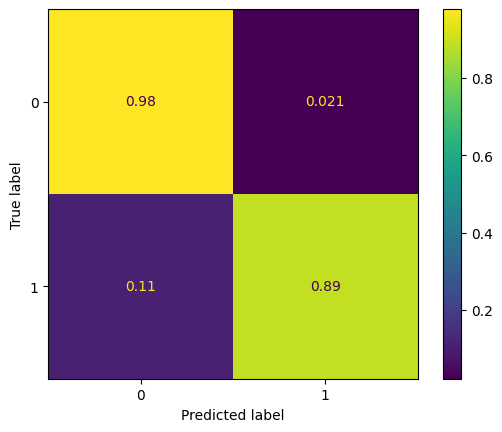

In [272]:
row0_sum = TN + FP
row1_sum = FN + TP

# Normalized by "true" (rows)
cf_norm_true = np.array([
    [TN / row0_sum, FP / row0_sum],
    [FN / row1_sum, TP / row1_sum]
])

cf_norm_true_disp = ConfusionMatrixDisplay(confusion_matrix=cf_norm_true)
cf_norm_true_disp.plot()

In [273]:
cf = np.array([[TN, FP],[FN, TP]])

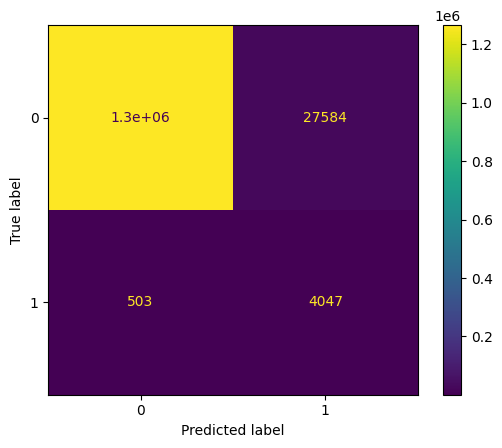

In [274]:
cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf)
cf_disp.plot()